## FermionOperator data structure

In [1]:
import openfermion 
openfermion.__version__

'0.11.1.dev'

In [2]:
from openfermion.ops import FermionOperator

Fermionic ladder operators are similar to qubit ladder operators but distinguished by the canonical fermionic *anticommutation* relations. 

These operators are represented by the `FermionicOperator` data structure, contained in `openfermion.ops`. 

This is implemented as a hash table for fast addition. The keys encode the strings of ladder operators and values store the coefficients. 

The strings are encoded as a tuple of 2-tuples, referred to as "terms tuple." Each ladder operator is represented by a 2-tuple. 

The first element of the 2-tuple is an integer indicated the tensor factor on which the ladder operator acts. The second element is a boolean: 1 means raising and 0 means lowering. $a_8^\dagger$ = (8, 1). 

Note that indices start at 0 and the identity operator is an empty list. 

When initializing a single ladder operator, add the comma after the inner pair because in Python `((a, b)) = (a, b)`.

In [3]:
single_wrong = FermionOperator(((3 ,1)))
print(single_wrong)
single = FermionOperator(((3, 1), ))
print(single)

1.0 [3^]
1.0 [3^]


In [4]:
identity = FermionOperator((),)
print(identity)
zero = FermionOperator()
print(zero)

1.0 []
0


To specify coefficient, provide an optional coefficient argument. DO NOT DO `1.5 * FermionOperator()` because this is slow. 

In [5]:
coeff_initialize = FermionOperator('3^ 1', -1.7)
print(coeff_initialize)

-1.7 [3^ 1]


FermionOperator has only one attribute: `terms`, a dictionary that stores the term tuples. 

In [6]:
my_operator = FermionOperator('4^ 1^ 3 9', 1. + 2.j)
print(my_operator)
print(my_operator.terms)

(1+2j) [4^ 1^ 3 9]
{((4, 1), (1, 1), (3, 0), (9, 0)): (1+2j)}


## Manipulating FermionOperator

Just use normal addition to combine two `FermionOperator` instances. Using `print()` will print each term on a separate line. 

In [7]:
my_op = FermionOperator('4^ 3^ 9 1', 1+2j)
t_2 = FermionOperator('3^ 1', -1.7)
my_op += t_2 # Use += is much more efficient since adds in-place
print(my_op)

-1.7 [3^ 1] +
(1+2j) [4^ 3^ 9 1]


There are many methods that act on the `FermionOperator` data structure. 

In [8]:
from openfermion.utils import commutator, count_qubits, \
    hermitian_conjugated, normal_ordered

print('Get Hermitian conjugate of a FermionOperator, count its qubit,\
        check if normal-ordered') 
term_1 = FermionOperator('4^ 3 3^', 1.+2.j)
print(term_1)
print(hermitian_conjugated(term_1))
print(term_1.is_normal_ordered())
print(count_qubits(term_1))

print('')
print('Normal order the term')
term_2 = normal_ordered(term_1)
print(term_2)
print(term_2.is_normal_ordered())

print('')
print('Compute a commutator of the terms')
print(commutator(term_1, term_2))

Get Hermitian conjugate of a FermionOperator, count its qubit,        check if normal-ordered
(1+2j) [4^ 3 3^]
(1-2j) [3 3^ 4]
False
5

Normal order the term
(1+2j) [4^] +
(-1-2j) [4^ 3^ 3]
True

Compute a commutator of the terms
(-3+4j) [4^ 3 3^ 4^] +
(3-4j) [4^ 3 3^ 4^ 3^ 3] +
(-3+4j) [4^ 3^ 3 4^ 3 3^] +
(3-4j) [4^ 4^ 3 3^]


## QubitOperator

The `QubitOperator` class has almost the same structure as `FermionOperator`, but it stores qubit operators like $X_0 Z_3 Y_4$. The internal representation of this example would be `((0, 'X'), (3, 'Z'), (4, 'Y'))`. 

An important difference between `FermionOperator` and `QubitOperator` is that for the latter, we must **always** sort in order of tensor factor. 

In [9]:
from openfermion.ops import QubitOperator

qubit_op = QubitOperator('X1 Y3 Z3')
print(qubit_op)
print(qubit_op.terms)

op_2 = QubitOperator(((3, 'X'), (4, 'Z')), 3.17)
op_2 -= .77 * qubit_op
print('')
print(op_2)

1j [X1 X3]
{((1, 'X'), (3, 'X')): 1j}

-0.77j [X1 X3] +
3.17 [X3 Z4]


## Jordan-Wigner and Bravyi-Kitaev

In [10]:
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.utils import eigenspectrum

# Initialize operator 
ferm_op = FermionOperator('2^ 0', 3.17)
ferm_op += hermitian_conjugated(ferm_op)
print(ferm_op)

# Transform to qubits with JW and print its spectrum 
print('')
jw_op = jordan_wigner(ferm_op)
print(jw_op)
jw_spectrum = eigenspectrum(jw_op)
print(jw_spectrum)

# Transform to qubits with BK and print its spectrum 
print('')
bk_op = bravyi_kitaev(ferm_op)
print(bk_op)
bk_spectrum = eigenspectrum(bk_op)
print(bk_spectrum)

3.17 [0^ 2] +
3.17 [2^ 0]

(1.585+0j) [X0 Z1 X2] +
(1.585+0j) [Y0 Z1 Y2]
[-3.17 -3.17  0.    0.    0.    0.    3.17  3.17]

(1.585+0j) [X0 Y1 Y2] +
(-1.585+0j) [Y0 Y1 X2]
[-3.17 -3.17  0.    0.    0.    0.    3.17  3.17]


Notice that the spectrum is the same for different representations. We can also reverse the JW transform to get a `FermionOperator`. 

In [11]:
from openfermion.transforms import reverse_jordan_wigner

# Map QubitOperator to FermionOperator
mapped_op = normal_ordered(reverse_jordan_wigner(jw_op))

print('Notice this is the same as what we started with:')
print(mapped_op)

Notice this is the same as what we started with:
(3.17+0j) [0^ 2] +
(3.17+0j) [2^ 0]


## Sparse matrices and the Hubbard model

Often, it's useful to obtain a sparse matrix representation of an operator to analyze numerically. `get_sparse_operator()` converts either a `FermionOperator`, `QubitOperator`, or other advanced classes like `InteractionOperator` to a `scipy.sparse.csc` matrix. 

Once we have this representation, we can use many functions from `openfermion.utils` like `get_gap()`, `get_hartree_fock_state()`, and `get_ground_state()`. 

Here we'll use some of these to compute the ground state energy of the Hubbard model. 

In [12]:
ffrom openfermion.hamiltonians import fermi_hubbard 
from openfermion.transforms import get_sparse_operator 
from openfermion.utils import get_ground_state

# Set model 
x_n = 2
y_n = 2 
tunneling = 2. 
coulomb = 1. 
mag_field = 0.5 
chem_potential = 0.25 
periodic = 1
spinless = 1 

# Get fermionic operator from Hubbard model 
hubbard = fermi_hubbard(
    x_n, y_n, tunneling, coulomb, chem_potential, mag_field, 
    periodic, spinless    
)
print(hubbard)

# Get qubit operator from JW 
jw_ham = jordan_wigner(hubbard)
jw_ham.compress()
print('')
print(jw_ham)

# Get scipy.sparse.csc representation 
sparse_op = get_sparse_operator(hubbard)
print('')
print(sparse_op)
print('')
print('My kernel keeps dying when calculating ground state, but I \
        can do up to 10x2 Hubbard on Google Compute!')
# print('Energy of the model is {} in units of T and J.'.format(
#     get_ground_state(sparse_op)[0]
# ))

-0.25 [0^ 0] +
1.0 [0^ 0 1^ 1] +
1.0 [0^ 0 2^ 2] +
-2.0 [0^ 1] +
-2.0 [0^ 2] +
-2.0 [1^ 0] +
-0.25 [1^ 1] +
1.0 [1^ 1 3^ 3] +
-2.0 [1^ 3] +
-2.0 [2^ 0] +
-0.25 [2^ 2] +
1.0 [2^ 2 3^ 3] +
-2.0 [2^ 3] +
-2.0 [3^ 1] +
-2.0 [3^ 2] +
-0.25 [3^ 3]

0.5 [] +
-1.0 [X0 X1] +
-1.0 [X0 Z1 X2] +
-1.0 [Y0 Y1] +
-1.0 [Y0 Z1 Y2] +
-0.375 [Z0] +
0.25 [Z0 Z1] +
0.25 [Z0 Z2] +
-1.0 [X1 Z2 X3] +
-1.0 [Y1 Z2 Y3] +
-0.375 [Z1] +
0.25 [Z1 Z3] +
-1.0 [X2 X3] +
-1.0 [Y2 Y3] +
-0.375 [Z2] +
0.25 [Z2 Z3] +
-0.375 [Z3]

  (1, 1)	(-0.25+0j)
  (2, 1)	(-2+0j)
  (4, 1)	(-2+0j)
  (1, 2)	(-2+0j)
  (2, 2)	(-0.25+0j)
  (8, 2)	(-2+0j)
  (3, 3)	(0.5+0j)
  (6, 3)	(2+0j)
  (9, 3)	(-2+0j)
  (1, 4)	(-2+0j)
  (4, 4)	(-0.25+0j)
  (8, 4)	(-2+0j)
  (5, 5)	(0.5+0j)
  (6, 5)	(-2+0j)
  (9, 5)	(-2+0j)
  (3, 6)	(2+0j)
  (5, 6)	(-2+0j)
  (6, 6)	(-0.5+0j)
  (10, 6)	(-2+0j)
  (12, 6)	(2+0j)
  (7, 7)	(1.25+0j)
  (11, 7)	(-2+0j)
  (13, 7)	(2+0j)
  (2, 8)	(-2+0j)
  (4, 8)	(-2+0j)
  (8, 8)	(-0.25+0j)
  (3, 9)	(-2+0j)
  (5, 9)	(-2+0j)
  (9, 9

## Hamiltonians in the plane wave basis 

Users can write plugins on openfermion. Some examples: computing molecular orbitals, Hamiltonians, energies, reduced density matrcies, or coupled cluster amplitudes using Gaussian basis sets. 

If you only need simpler basis sets, Openfermion comes with code to compute Hamiltonians in the plane wave basis. When using plane waves, one is working with the periodized Coulomb operator, which works best for condensed phase calculations, like studying electronic structure of a solid. 

To get the Hamiltonians, we must prepare the system to be spinless and specify the dimension in which the calculations are performed, and how many plane waves are in each dimension (`grid_length`), and specify the length scale of the plane wave harmonics in each dimension (`length_scale`), and the locations and charges of the nuclei. 

We only need to use the `openfermion.hamiltonians.plane_wave_hamiltonian()` function to do this. 

In the following example, we compute the Hamiltonian in the case of zero external charge (a uniform electron gas aka Jellium). We also demonstrate we can transform the plane wave Hamiltonian using a Fourier transform without effecting the spectrum of the operator. 

In [13]:
from openfermion.hamiltonians import jellium_model
from openfermion.utils import fourier_transform, Grid 

print("Let's check out a tiny model of Jellium in 1D")
grid = Grid(dimensions=1, length=3, scale=1.0)
spinless = True 

print("\nGet the momentum Hamiltonian") 
mom_ham = jellium_model(grid, spinless) 
mom_qubit_op = jordan_wigner(mom_ham)
mom_qubit_op.compress() 
print(mom_qubit_op)

print("\nFourier transform the Hamiltonian to the position basis")
pos_ham = fourier_transform(mom_ham, grid, spinless)
pos_qubit_op = jordan_wigner(pos_ham)
pos_qubit_op.compress()
print(pos_qubit_op)

print("\nCheck the spectra to make sure these representations are iso-spectral") 
spectral_diff = eigenspectrum(mom_qubit_op) - eigenspectrum(pos_qubit_op)
print(spectral_diff)
print('\nThese values are all close to 0. ')

Let's check out a tiny model of Jellium in 1D

Get the momentum Hamiltonian
19.50047638754088 [] +
-9.71044945799746 [Z0] +
-0.07957747154594767 [Z0 Z1] +
-0.07957747154594767 [Z0 Z2] +
0.15915494309189535 [Z1] +
-0.07957747154594767 [Z1 Z2] +
-9.71044945799746 [Z2]

Fourier transform the Hamiltonian to the position basis
19.500476387540854 [] +
-3.289868133696451 [X0 X1] +
-3.289868133696454 [X0 Z1 X2] +
-3.289868133696451 [Y0 Y1] +
-3.289868133696454 [Y0 Z1 Y2] +
-6.420581324301009 [Z0] +
-0.07957747154594766 [Z0 Z1] +
-0.07957747154594763 [Z0 Z2] +
-3.289868133696451 [X1 X2] +
-3.289868133696451 [Y1 Y2] +
-6.4205813243010095 [Z1] +
-0.07957747154594766 [Z1 Z2] +
-6.420581324301009 [Z2]

Check the spectra to make sure these representations are iso-spectral
[2.75474088e-14 2.66175970e-14 2.84217094e-14 7.10542736e-15
 2.84217094e-14 2.13162821e-14 1.42108547e-14 7.10542736e-15]

These values are all close to 0. 


## MolecularData class

We can save data from electronic structure calculations in a data structure called `MolecularData`. 

We might need to analyze many different Hamiltonians, but because the electronic structure calculations are either expensive to compute or difficult to converge, it'd be nice if there was a way to automatically store results of the calculations to that important data (like the SCF integrals) can be looked up on-the-fly if computed in the past. Openfermion supports a strategy which saves key results of the calculations (including pointers to files containing large amounts of data like molecular integrals) in an HDF5 container. 

The `MolecularData` class stores info about molecules. We initialize it by specifying parameters of a molecule. Or we can initialize it by providing a string giving a filename where a previous `MolecularData` object was stored in an HDF5 container. We can save our instance by calling `.save()` with an optional filename (stores in data folder specified during OpenFermion installation). 

When calculations are run, the data files can be automatically updated. 

To specify parameters for instantiation: 
- basis functions are strings like "6-31g" 
- geometries are specified using a .txt file (see geometry_from_file() in `molecular_data.py`) or can be passed using a Python list format like in the example below. 
- atoms are specified using a string for their atomic symbol 
- distances are provided in angstrom 

In [14]:
from openfermion.hamiltonians import MolecularData 

# Set parameters 
diatomic_bond_length = .7414 
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
basis = 'sto-3g'
multiplicity = 1 
charge = 0 
description = str(diatomic_bond_length)

# Make molecule and print out a few interesting facts about it. 
molecule = MolecularData(geometry, basis, multiplicity, charge, description)

print('Molecule has automatically generated from {}'.format(
    molecule.name))
print('Information about this molecule would be saved at:\n{}\n'.format(
    molecule.filename))
print('This molecule has {} atoms and {} electrons.'.format(
    molecule.n_atoms, molecule.n_electrons))
for atom, atomic_number in zip(molecule.atoms, molecule.protons):
    print('Contains {} atom, which has {} protons.'.format(
        atom, atomic_number))

Molecule has automatically generated from H2_sto-3g_singlet_0.7414
Information about this molecule would be saved at:
/home/warren/OpenFermion/src/openfermion/data/H2_sto-3g_singlet_0.7414

This molecule has 2 atoms and 2 electrons.
Contains H atom, which has 1 protons.
Contains H atom, which has 1 protons.


If we had previously computed this molecule, we can call `molecule.load()` to populate all sorts of interesting fields in the data structure. We assume calculations are saved in OpenFermions's `MolecularData` objects. Plugins are available for Psi4 and PySCF. 

In the next example, we load data that comes with OpenFermion to plot the energy surface of hydrogen. 

Bond length:  0.3

At bond length of 0.30000000000000004 angstrom, molecular hydrogen has:
Hartree-Fock energy of -0.59382776458494 Hartree.
MP2 energy of -0.5997818888874376 Hartree.
FCI energy of -0.6018037168352988 Hartree.
Nuclear repulsion energy between protons is 1.7639240286333335 Hartree.
Spatial orbital 0 has energy of -0.8028666187118976 Hartree.
Spatial orbital 1 has energy of 1.368938795250223 Hartree.
Bond length:  0.4

At bond length of 0.4 angstrom, molecular hydrogen has:
Hartree-Fock energy of -0.904361397713845 Hartree.
MP2 energy of -0.9114367296997896 Hartree.
FCI energy of -0.9141497082141279 Hartree.
Nuclear repulsion energy between protons is 1.322943021475 Hartree.
Spatial orbital 0 has energy of -0.7452125332909346 Hartree.
Spatial orbital 1 has energy of 1.167416395038123 Hartree.
Bond length:  0.5

At bond length of 0.5 angstrom, molecular hydrogen has:
Hartree-Fock energy of -1.0429962765072203 Hartree.
MP2 energy of -1.0514858618835026 Hartree.
FCI energy 


At bond length of 2.5 angstrom, molecular hydrogen has:
Hartree-Fock energy of -0.7029435983728299 Hartree.
MP2 energy of -0.8535394695489013 Hartree.
FCI energy of -0.9360549198442759 Hartree.
Nuclear repulsion energy between protons is 0.21167088343600005 Hartree.
Spatial orbital 0 has energy of -0.2144671917818725 Hartree.
Spatial orbital 1 has energy of 0.04995242289757026 Hartree.


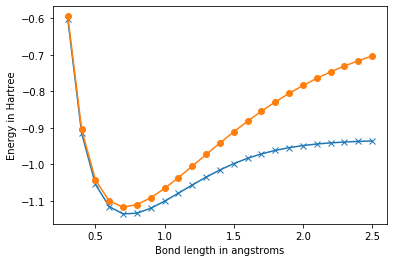

In [15]:
# Set molecule parameters 
basis = 'sto-3g'
multiplicity = 1 
bond_length_interval = 0.1 
n_points = 25 

# Generate molecule at different bond lengths 
hf_energies = []
fci_energies = []
bond_lengths = []

for point in range(3, n_points+1):
    bond_length = bond_length_interval * point 
    bond_lengths.append(bond_length)
    description = str(round(bond_length, 2))
    print('Bond length: ', description)
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, description=description)
    
    # Load data 
    molecule.load()
    
    # Print out some results of calculation 
    print('\nAt bond length of {} angstrom, molecular hydrogen has:'.format(
        bond_length))
    print('Hartree-Fock energy of {} Hartree.'.format(molecule.hf_energy))
    print('MP2 energy of {} Hartree.'.format(molecule.mp2_energy))
    print('FCI energy of {} Hartree.'.format(molecule.fci_energy))
    print('Nuclear repulsion energy between protons is {} Hartree.'.format(
        molecule.nuclear_repulsion))
    for orbital in range(molecule.n_orbitals):
        print('Spatial orbital {} has energy of {} Hartree.'.format(
            orbital, molecule.orbital_energies[orbital]))
    hf_energies.append(molecule.hf_energy)
    fci_energies.append(molecule.fci_energy)

# Plot 
import matplotlib.pyplot as plt 
%matplotlib inline 

plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'x-')
plt.plot(bond_lengths, hf_energies, 'o-')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstroms')
plt.show()

The geometry data needed to generate `MolecularData` can also be retrieved from PubChem online database by inputting the molecule's name. **(Need to look into this)**

In [16]:
from openfermion.utils import geometry_from_pubchem

methane_geometry = geometry_from_pubchem('methane')
print(methane_geometry)

[('C', (0, 0, 0)), ('H', (0.5541, 0.7996, 0.4965)), ('H', (0.6833, -0.8134, -0.2536)), ('H', (-0.7782, -0.3735, 0.6692)), ('H', (-0.4593, 0.3874, -0.9121))]


# InteractionOperator and InteractionRDM for efficient numerical representation

We can write fermion Hamiltonians as 
$$ \large H = h_0 + \sum_{pq} h_{pq} a_p^\dagger a_q + \frac{1}{2} \sum_{pqrs} h_{pqrs} a_p^\dagger a_q^\dagger a_r a_s $$ 
where $h_0$ is a constant due to the nuclear repulsion, and $h_{pq}$ and $h_{pqrs}$ are molecular integrals. 

*Way more info to read.* 

Below, we load `MolecularData` from a saved calculation of LiH, then we obtain an `InteractionOperator` representation of this system in active space (what's active space?), then we map that operator to qubits, then we demonstrate that we can rotate the orbital basis of the `InteractionOperator` using random angles to obtain a totally different operator that is still iso-spectral. 

In [17]:
from openfermion.transforms import get_fermion_operator
import numpy as np
import scipy 
import scipy.linalg

# Load saved file for LiH 
diatomic_bond_length = 1.45 
geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
basis = 'sto-3g'
multiplicity = 1 

# Set Hamiltonian parameters 
# What are these? 
active_space_start = 1 
active_space_stop = 3 

# Generate and populate instance of MolecularData 
molecule = MolecularData(geometry, basis, multiplicity, description='1.45')
molecule.load()

# Get Hamiltonian in an active space 
molecular_ham = molecule.get_molecular_hamiltonian(
    occupied_indices=range(active_space_start), 
    active_indices=range(active_space_start, active_space_stop)
)

# Map operator to fermions then to qubits 
ferm_ham = get_fermion_operator(molecular_ham)
qubit_ham = jordan_wigner(ferm_ham)
qubit_ham.compress()
print("The JW Hamiltonian in canonical basis follows:\n{}".format(qubit_ham))

# Get sparse operator and ground state energy 
sparse_ham = get_sparse_operator(qubit_ham)
#energy, state = get_ground_state(sparse_ham)
# print('\nGround state energy before rotation is {} Hartree.\n'.format(energy))

# Randomly rotate 
n_orbitals = molecular_ham.n_qubits // 2 
n_variables = int(n_orbitals * (n_orbitals - 1) / 2)
np.random.seed(42)
random_angles = np.pi * (1. - 2. * np.random.rand(n_variables))
kappa = np.zeros((n_orbitals, n_orbitals))
index = 0 
for p in range(n_orbitals):
    for q in range(p+1, n_orbitals):
        kappa[p, q] = random_angles[index]
        kappa[q, p] = -np.conjugate(random_angles[index])
        index += 1
        
    # Build unitary rotation matrix 
    diff_matrix = kappa + kappa.transpose()
    rot_matrix = scipy.linalg.expm(kappa)

    # Apply the unitary 
    molecular_ham.rotate_basis(rot_matrix)
        
# Get qubit Hamiltonian in rotated basis 
qubit_ham = jordan_wigner(molecular_ham)
qubit_ham.compress()
print('\nThe JW Hamiltonian in rotated basis follows:\n{}'.format(qubit_ham))

# Get sparse Hamiltonian and energy in rotated basis 
sparse_ham = get_sparse_operator(qubit_ham)
#energy, state = get_ground_state(sparse_ham)
# print('Ground state energy after rotation is {} Hartree.'.format(energy))

print('\nAgain, my kernel dies when finding the ground state but it works on Google Compute')

The JW Hamiltonian in canonical basis follows:
-7.49894690201071 [] +
-0.0029329964409502266 [X0 X1 Y2 Y3] +
0.0029329964409502266 [X0 Y1 Y2 X3] +
0.01291078027311749 [X0 Z1 X2] +
-0.0013743761078958677 [X0 Z1 X2 Z3] +
0.011536413200774975 [X0 X2] +
0.0029329964409502266 [Y0 X1 X2 Y3] +
-0.0029329964409502266 [Y0 Y1 X2 X3] +
0.01291078027311749 [Y0 Z1 Y2] +
-0.0013743761078958677 [Y0 Z1 Y2 Z3] +
0.011536413200774975 [Y0 Y2] +
0.16199475388004184 [Z0] +
0.011536413200774975 [Z0 X1 Z2 X3] +
0.011536413200774975 [Z0 Y1 Z2 Y3] +
0.12444770133137588 [Z0 Z1] +
0.054130445793298836 [Z0 Z2] +
0.05706344223424907 [Z0 Z3] +
0.012910780273117487 [X1 Z2 X3] +
-0.0013743761078958677 [X1 X3] +
0.012910780273117487 [Y1 Z2 Y3] +
-0.0013743761078958677 [Y1 Y3] +
0.16199475388004186 [Z1] +
0.05706344223424907 [Z1 Z2] +
0.054130445793298836 [Z1 Z3] +
-0.013243698330265966 [Z2] +
0.08479609543670981 [Z2 Z3] +
-0.013243698330265952 [Z3]

The JW Hamiltonian in rotated basis follows:
-7.498946902010707 [] +


## Quadratic Hamiltonians and Slater determinants 

In the above decomposition of the general electronic structure Hamiltonian, we had terms that act on 4 sites (quartic in the fermion creation and annihilation operators), but in many situations we can accurately approximate these by replacing them with terms that act on at most 2 fermionic sites (quadratic terms) like in mean-field approximation theory (What's this?). 

We call these quadratic Hamiltonians, and they have properties which allow for efficient simulation, so we give them their own data structure available with `openfermion.transforms.get_quadratic_hamiltonian()` which gives the `QuadraticHamiltonian` class. 

Eigenstates of quadratic Hamiltonians can be prepared efficiently on classical and quantum computers. 

The general case of non-particle conserving terms as in a general Bogoliubov transformation. 

A general quadratic Hamiltonian takes the form: 
$$\large H = \sum_{pq} (M_{pq} - \mu \delta_{pq}) a_p^\dagger a_q + \frac{1}{2} \sum_{pq}(\Delta_{pq} a_p^\dagger a_q^\dagger + \Delta^{*}_{pq} a_q a_p ) + constant $$

where $M$ is Hermitian, $\Delta$ is an antisymmetric matrix, $\delta_{pq}$ is the Kronecker delta, and $\mu$ is a chemical potential term, which is kept separate from $M$ so we can adjust the expectation of the total number of particles. 

The `QuadraticHamiltonian` class stores $M$, $\Delta$, $\mu$, and the constant. It also inherits from `PolynomialTensor` class like `InteractionOperator` and `InteractionRDM`. 

THE BCS mean-field model of superconductivity is a quadratic Hamiltonian. Below, we create an instance of this model as a `FermionOperator`, convert it to a `QuadraticHamiltonian`, then compute its ground energy: 

In [18]:
from openfermion.hamiltonians import mean_field_dwave 
from openfermion.transforms import get_quadratic_hamiltonian 

# Set model 
x_n = 2 
y_n = 2 
tunneling = 2.
sc_gap = 1. 
periodic = True 

# Get FermionOperator 
mean_field_model = mean_field_dwave(x_n, y_n, tunneling, sc_gap, periodic=periodic)

# Convert to QuadraticHamiltonian 
quad_ham = get_quadratic_hamiltonian(mean_field_model)

# Compute ground energy 
ground_energy = quad_ham.ground_energy()
print(ground_energy)

-9.99999999999999


**Wow! To illustrate how much more computationall efficient this is, consider for a moment that my computer was actually able to compute the ground energy for this one quickly.**

We can rewrite any quadratic Hamiltonian in the form 
$$\large H = \sum_p \epsilon_p b_p^\dagger b_p + constant $$ 
where $b_p$ are new annihilation operators that satisfy the fermionic anticommutation relations and which are linear combinations of the old fermionic annihilation operators $a_p$. 

This form allows us to easily find the eigenvalues: they are linear combinations of the $\epsilon_p$, which we call the orbital energies of $H$. 

In [19]:
orbital_energies, constant = quad_ham.orbital_energies()
print(orbital_energies)
print('')
print(constant)

[1. 1. 1. 1. 4. 4. 4. 4.]

-9.99999999999999


Eigenstates of quadratic Hamiltonians are called **fermionic Gaussian states** (are these related to Gaussian basis?) and can be prepared efficiently on a quantum computer. 

OpenFermion can tell us which circuit to use to prepare these states. Below we obtain the description of a circuit which prepares the ground state and a description of the starting state. 

Operations that are parallelizable are grouped together. 

In the circuit description, we either have 
- a tuple ($i, j, \theta, \psi$), which indicates $\exp( i \psi a_j^\dagger a_j) \exp[ \theta(a_i^\dagger a_j - a_j^\dagger a_i )]$, which is a rotation of modes $i$ and $j$ (how?) 
- the string 'pht', which indicates the *particle-hole transformation* on the last fermionic mode, which is the operator $B$ such that $B a_N B^\dagger = a_N^\dagger$ and leaves the rest of the ladder operators unchanged (why is this guaranteed to exist?) 

In [20]:
from openfermion.utils import gaussian_state_preparation_circuit 

circuit_desc, start_orbitals = gaussian_state_preparation_circuit(quad_ham)
for parallel_ops in circuit_desc:
    print(parallel_ops)
print('')
print(start_orbitals)

('pht',)
((6, 7, 1.5707963267948966, 0.0),)
('pht', (5, 6, 1.5707963267948966, 0.0))
((4, 5, 1.0471975511965976, 3.141592653589792), (6, 7, 1.0471975511965974, -3.1415926535897927))
('pht', (3, 4, 1.5707963267948966, 0.0), (5, 6, 1.5707963267948966, 0.0))
((2, 3, 1.230959417340775, -5.10702591327572e-15), (4, 5, 1.230959417340775, -5.551115123125783e-16), (6, 7, 1.1071487177940904, -3.1415926535897922))
('pht', (1, 2, 1.5707963267948966, 0.0), (3, 4, 1.5707963267948966, 0.0), (5, 6, 1.5707963267948966, 0.0))
((0, 1, 1.047197551196598, 3.141592653589793), (2, 3, 1.0471975511965974, 3.141592653589792), (4, 5, 1.3181160716528177, -3.14159265358979), (6, 7, 1.3181160716528177, -3.330669073875469e-16))
('pht', (1, 2, 1.5707963267948966, 0.0), (3, 4, 1.5707963267948966, 0.0), (5, 6, 1.5707963267948966, 0.0))
((2, 3, 0.9553166181245089, 6.661338147750939e-16), (4, 5, 0.9553166181245096, 3.330669073875469e-16), (6, 7, 1.1071487177940906, -1.1102230246251565e-16))
('pht', (3, 4, 1.5707963267948

For the special case that a quadratic Hamiltonian conserves particle number ($\Delta = 0$), its eigenstates take the form: 
$$ \mid \psi_s \rangle = b_1^\dagger \cdots b_N^\dagger \mid vac \rangle $$ 
where $$ b_p^\dagger = \sum_{k=1}^N Q_{pq} a_q^\dagger$$ 
where $Q$ is an $N x N$ matrix with orthonormal rows. 

These states are known as Slater determinants, and OpenFermion provides functionality to obtain circuits for preparing Slater determinants starting with matrix $Q$ as input. 